# Создание собственных распределений в Python

Рассмотрим функцию $$ \varphi(x) = \frac{1}{2} \sin x, \quad x \in [0, \pi], $$ которая является плотностью вероятности непрерывной случайной величины.

Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous
from scipy import integrate

Перед тем, как создать класс для собственного распределения, найдём функцию распределения по известной функции плотности:

$$ F(x)=\int_{-\infty}^{x}{\varphi(x) dx}=\int_{-\infty}^{x}{0 dx}=0, \quad x \in [-\infty, 0) $$
$$ F(x)=\int_{-\infty}^{x}{\varphi(x) dx}=\int_{-\infty}^{0}{0 dx}+\int_{0}^{x}{\frac{1}{2} \sin x dx}=\int_{0}^{x}{\frac{1}{2} \sin x dx}=-\frac{1}{2} \cos x \Bigg|_0^x=\frac{1}{2}-\frac{1}{2} \cos x, \quad x \in [0, \pi] $$
$$ F(x)=\int_{-\infty}^{x}{\varphi(x) dx}=\int_{-\infty}^{0}{0 dx}+\int_{0}^{\pi}{\frac{1}{2} \sin x dx}+\int_{\pi}^{x}{0 dx}=\int_{0}^{\pi}{\frac{1}{2} \sin x dx}=-\frac{1}{2} \cos x \Bigg|_0^\pi=\frac{1}{2}+\frac{1}{2}=1, \quad x \in (\pi, +\infty] $$

Таким образом:

$$ F(x)=\begin{cases} 0, & x \in [-\infty, 0), \\ \frac{1}{2}-\frac{1}{2} \cos x, & x \in [0, \pi], \\ 1, & x \in (\pi, +\infty]. \end{cases} $$

Найдём квантильную функцию:

$$F(x_q)=\frac{1}{2}(1-\cos(x_q))=q$$
$$1-\cos(x_q)=2q$$
$$\cos(x_q)=1-2q$$
$$x_q=arccos(1-2q)$$

Создадим класс для собственного распределения:

In [39]:
class CustomDistribution(rv_continuous):
    def __init__(self, a, b):
        super().__init__(a=a, b=b, name='custom_dist')

    def _pdf(self, x):
        """Плотность распределения"""
        result = np.zeros_like(x)
        result[(x >= self.a) & (x <= self.b)] = 1 / 2 * np.sin(x)
        return result

    def _cdf(self, x):
        """Функция распределения"""
        result = np.zeros_like(x)
        result[x < self.a] = 0
        result[(x >= self.a) & (x <= self.b)] = 1 / 2 - 1 / 2 * np.cos(x)
        result[x > self.b] = 1
        return result

    def _ppf(self, q):
        """Квантильная функция"""
        return np.arccos(1 - 2 * q)


a, b = 0, np.pi
custom_dist = CustomDistribution(a, b)  # создаем экземпляр распределения

np.random.seed(42)
sample = custom_dist.rvs(size=10_000)   # генерация выборки

print(f"Размер выборки: {len(sample)}")
values = ', '.join(f"{x:.3f}" for x in sample[:10])
print(f"Первые 10 значений: {values}")

x_test = np.linspace(a - 0.5, b + 0.5, 100)
pdf_values = custom_dist.pdf(x_test)
cdf_values = custom_dist.cdf(x_test)

Размер выборки: 10000
Первые 10 значений: 1.317, 2.694, 2.053, 1.769, 0.812, 0.812, 0.487, 2.393, 1.774, 2.000


Приверим условие нормировки плотности:

In [22]:
print("Проверка нормировки плотности:")
integral, error = integrate.quad(custom_dist.pdf, a, b)
print(f"∫f(x)dx на [{a}, {b}] = {integral:.3f} (ошибка: {error:.2e})")

Проверка нормировки плотности:
∫f(x)dx на [0, 3.141592653589793] = 1.000 (ошибка: 1.11e-14)


**Условие нормировки выполнено.**

Построим графики плотности и функции распределения:

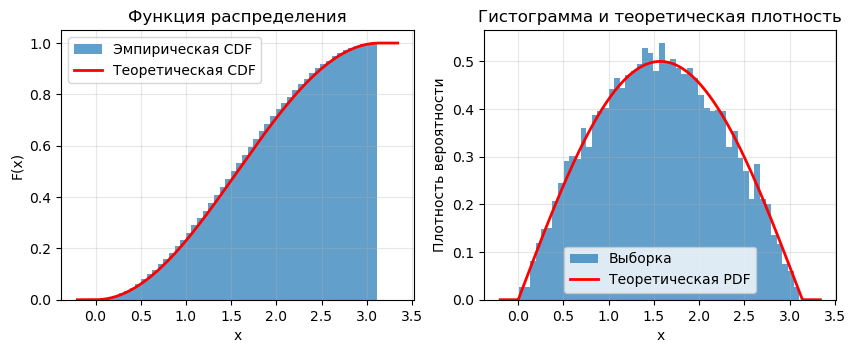

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
x_plot = np.linspace(a - 0.2, b + 0.2, 1000)

# 1. Функция распределения
ax1.hist(sample, bins=50, density=True, cumulative=True, alpha=0.7, label='Эмпирическая CDF')
ax1.plot(x_plot, custom_dist.cdf(x_plot), 'r-', linewidth=2, label='Теоретическая CDF')
ax1.set_xlabel('x')
ax1.set_ylabel('F(x)')
ax1.set_title('Функция распределения')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Гистограмма и теоретическая плотность
ax2.hist(sample, bins=50, density=True, alpha=0.7, label='Выборка')
ax2.plot(x_plot, custom_dist.pdf(x_plot), 'r-', linewidth=2, label='Теоретическая PDF')
ax2.set_xlabel('x')
ax2.set_ylabel('Плотность вероятности')
ax2.set_title('Гистограмма и теоретическая плотность')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

Рассчитаем вероятность попадания СВ в интервал $\left[\frac{\pi}{4};\frac{3\pi}{4}\right]$:

$$P(\frac{\pi}{4} \leq X \leq \frac{3\pi}{4})=F(\frac{3\pi}{4})-F(\frac{\pi}{4})$$

In [27]:
print("Вероятность попадания СВ в интервал [pi/4; 3pi/4]:")
print(custom_dist.cdf(3 * np.pi / 4) - custom_dist.cdf(np.pi / 4))

Вероятность попадания СВ в интервал [pi/4; 3pi/4]:
0.7071067811865475


Вычислим математическое ожидание, дисперсию и среднее квадратическое отклонение:

In [28]:
print(f"Математическое ожидание: {custom_dist.mean():.4f}")
print(f"Дисперсия: {custom_dist.var():.4f}")
print(f"Среднее квадратическое отклонение: {custom_dist.std():.4f}")

Математическое ожидание: 1.5708
Дисперсия: 0.4674
Среднее квадратическое отклонение: 0.6837


Вычислим квантиль уровня 0.14 и 76%-ную точку СВ:

In [40]:
print(f"Квантиль уровня 0.14: {custom_dist.ppf(0.14):.4f}")
print(f"76%-ная точка: {custom_dist.ppf(0.24):.4f}")

Квантиль уровня 0.14: 0.7670
76%-ная точка: 1.0239


Определим коэффициент асимметрии и эксцесс:

In [53]:
# третий центральный момент:
mean = custom_dist.mean()

def integrand3(x):
    return (x - mean) ** 3 * custom_dist.pdf(x)

mu3, error = integrate.quad(integrand3, -np.inf, np.inf)
print(f"Третий центральный момент: {mu3:.4f}")

# коэффициент асимметрии:
A = mu3 / (custom_dist.std()) ** 3
print(f"Коэффициент асимметрии: {A:.4f}")

Третий центральный момент: 0.0000
Коэффициент асимметрии: 0.0000


In [51]:
# четвёртый центральный момент:
def integrand4(x):
    return (x - mean) ** 4 * custom_dist.pdf(x)

mu4, error = integrate.quad(integrand4, -np.inf, np.inf)
print(f"Четвёртый центральный момент: {mu4:.4f}")

# эксцесс:
E = (mu4 / (custom_dist.std()) ** 4) - 3
print(f"Эксцесс: {E:.4f}")

Четвёртый центральный момент: 0.4793
Эксцесс: -0.8062
